PGE :-




C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means (PCA) Silhouette Score: 0.13850995898246765, V-measure Score: 0.3222897661691766


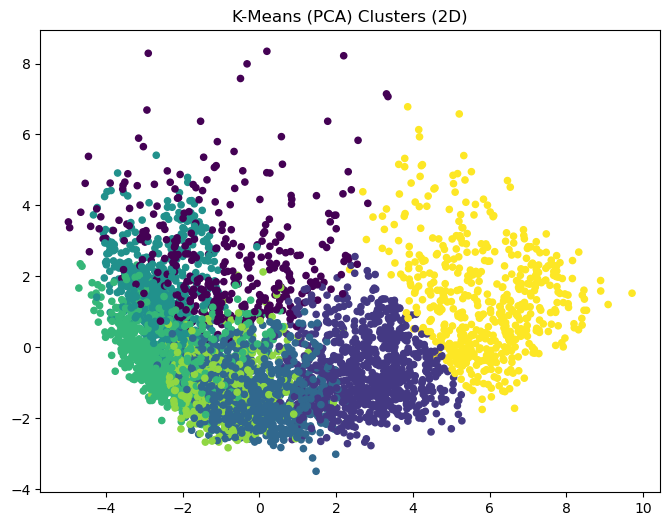

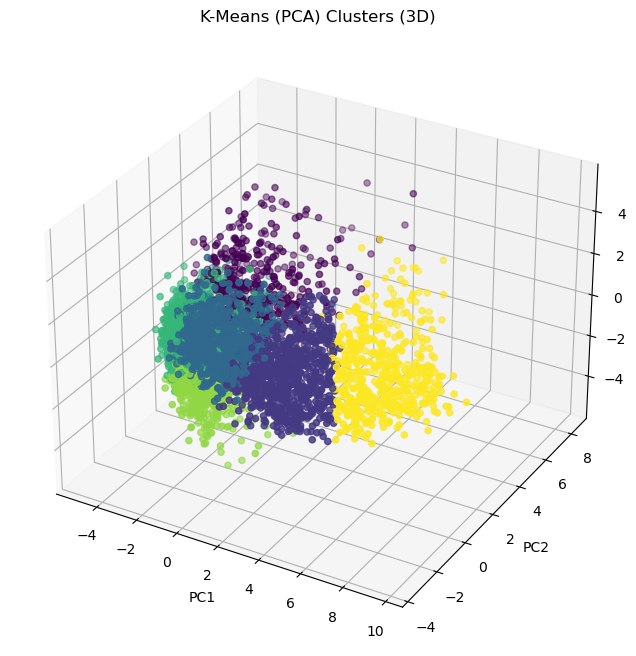

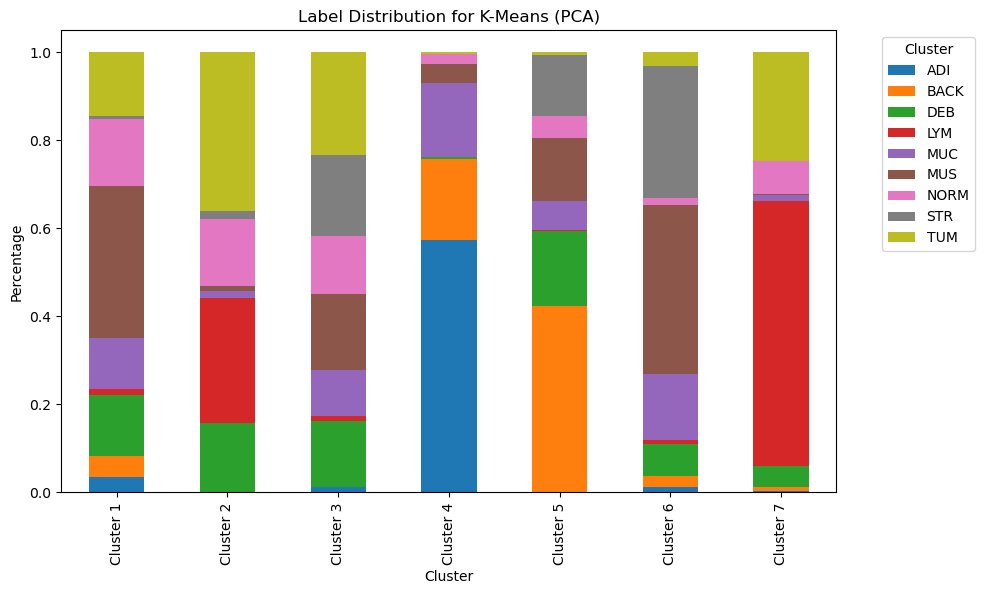

C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means (UMAP) Silhouette Score: 0.6156871914863586, V-measure Score: 0.5243630286481957


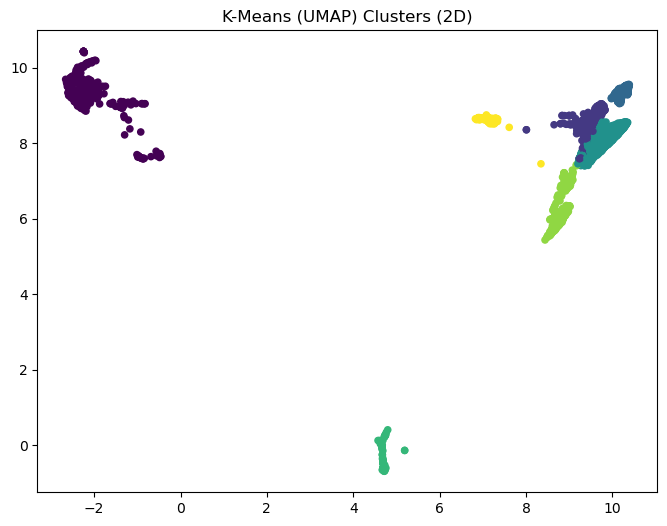

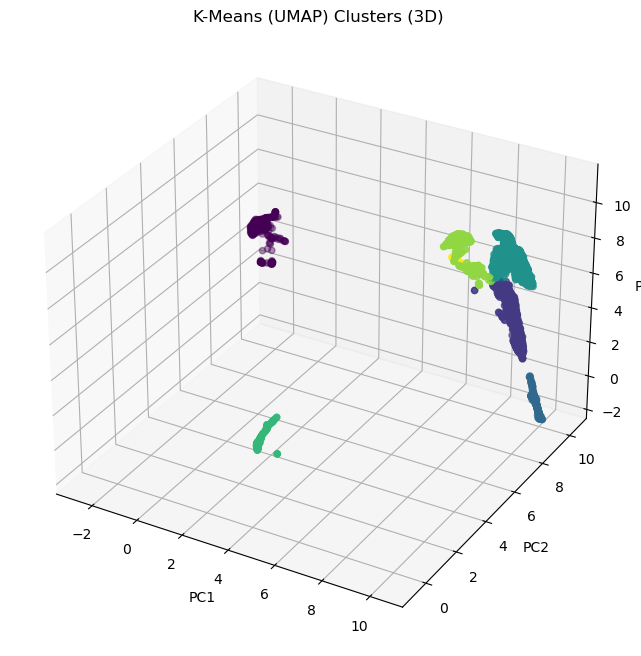

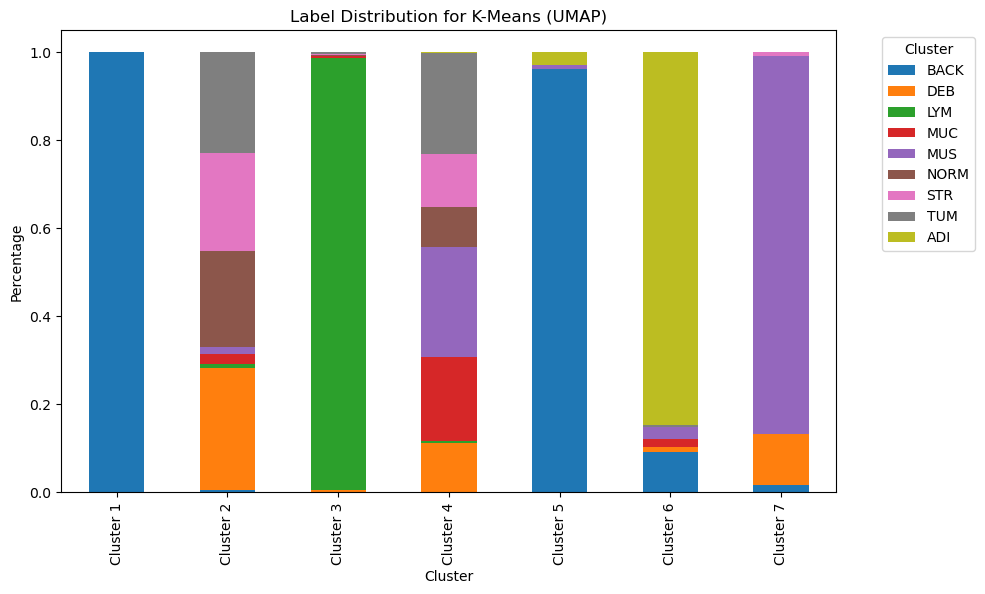

Gaussian Mixture Model (PCA) Silhouette Score: 0.13798661530017853, V-measure Score: 0.3778095348496037


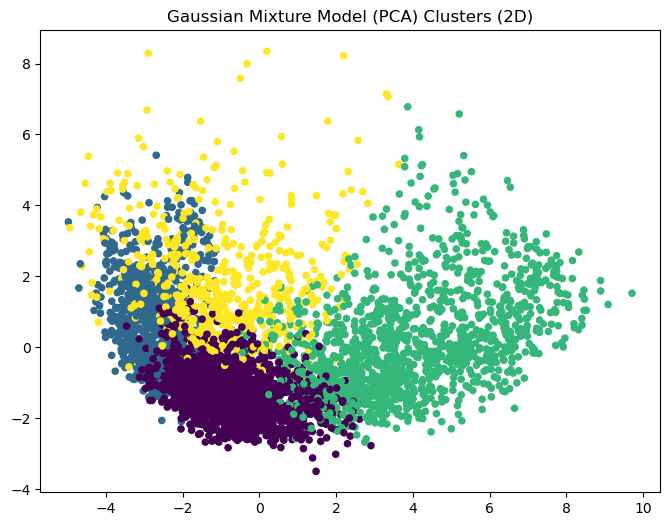

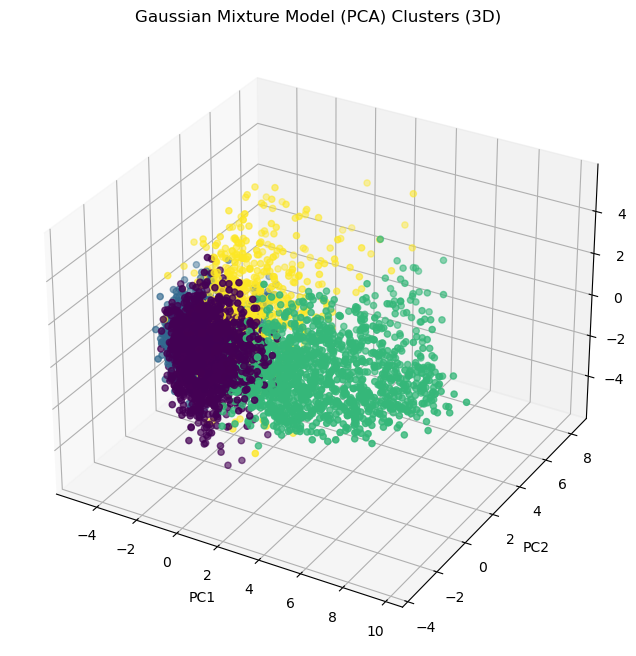

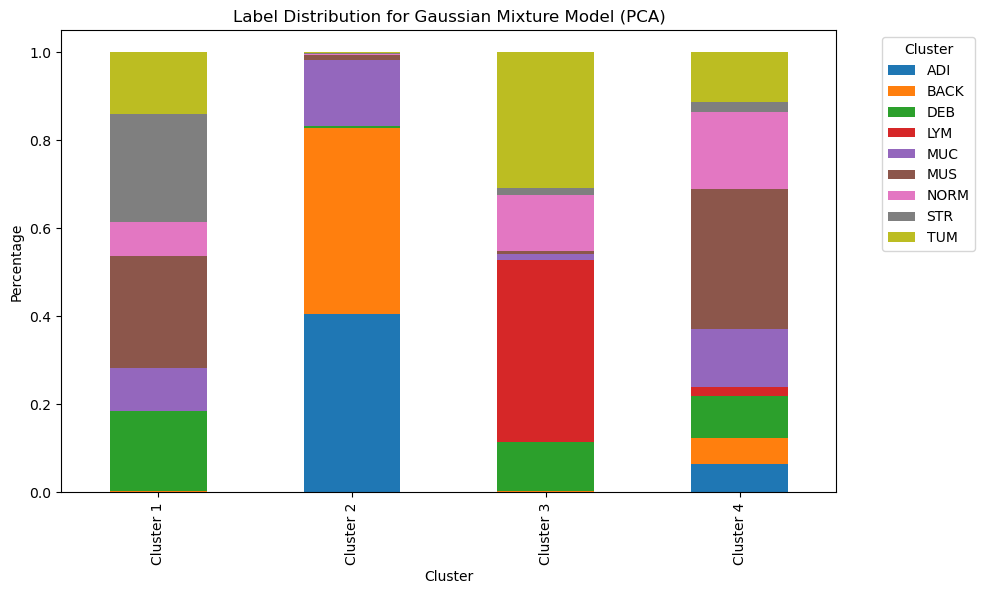

GMM (UMAP) Silhouette Score: 0.5875770449638367, V-measure Score: 0.5069566043034589


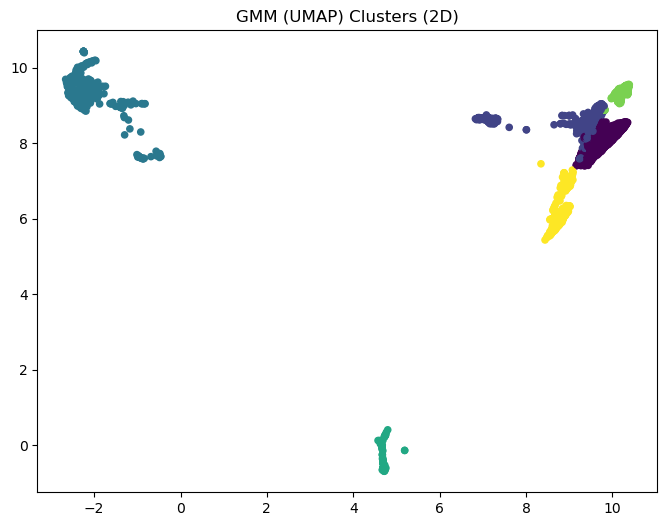

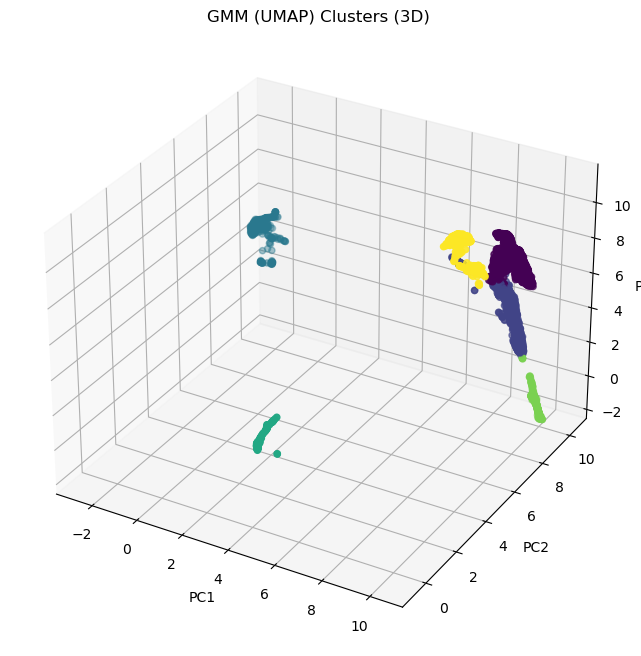

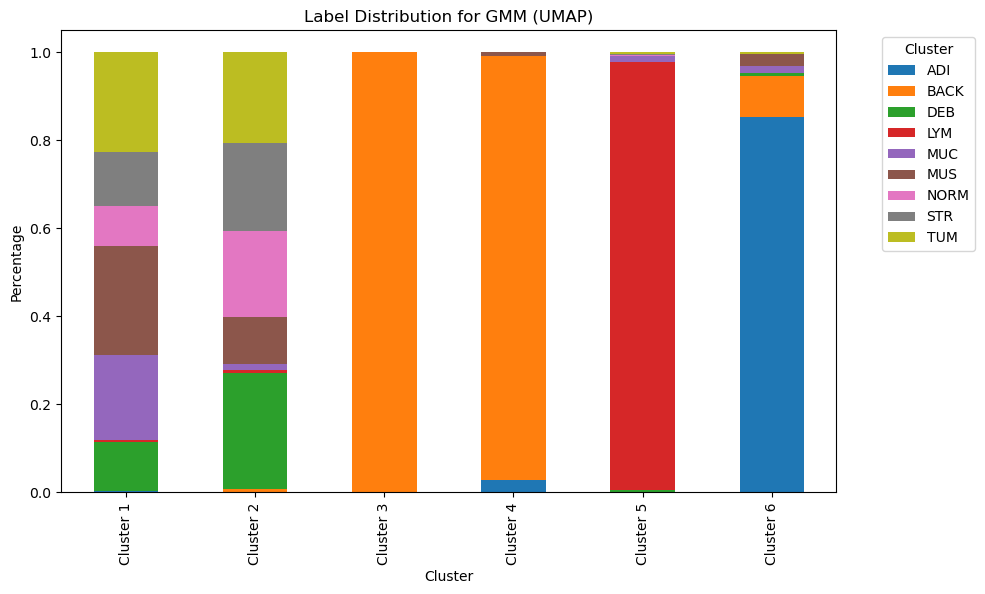

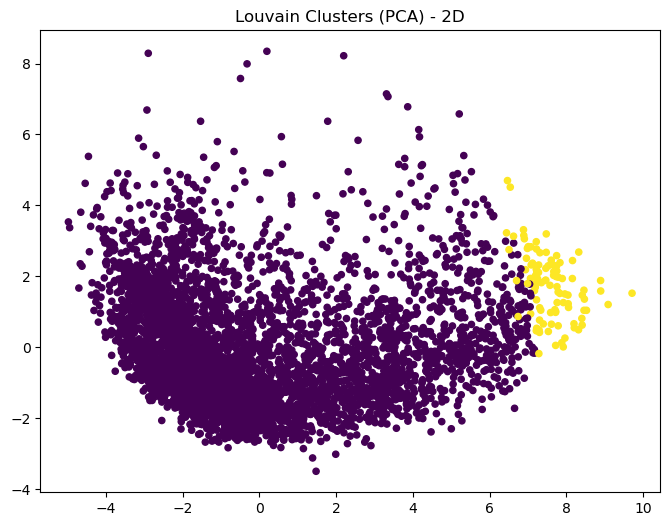

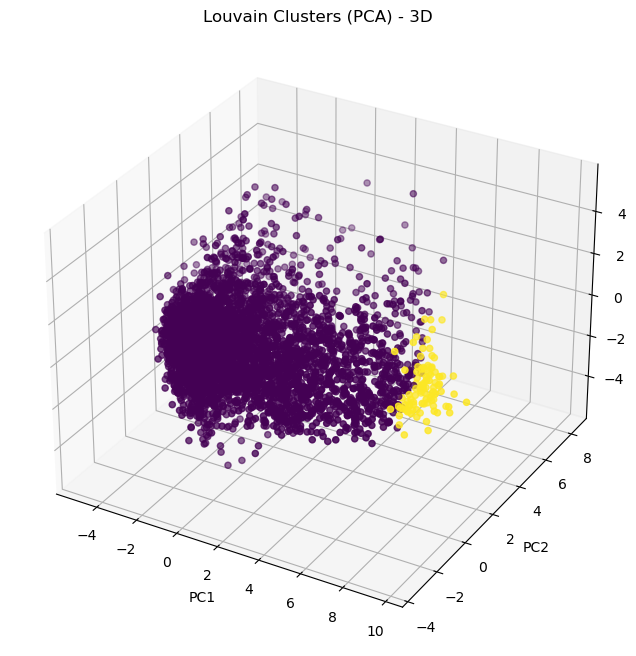


Louvain Clustering (PCA) Silhouette Score: 0.35051143169403076, V-measure Score: 0.027988843936467375


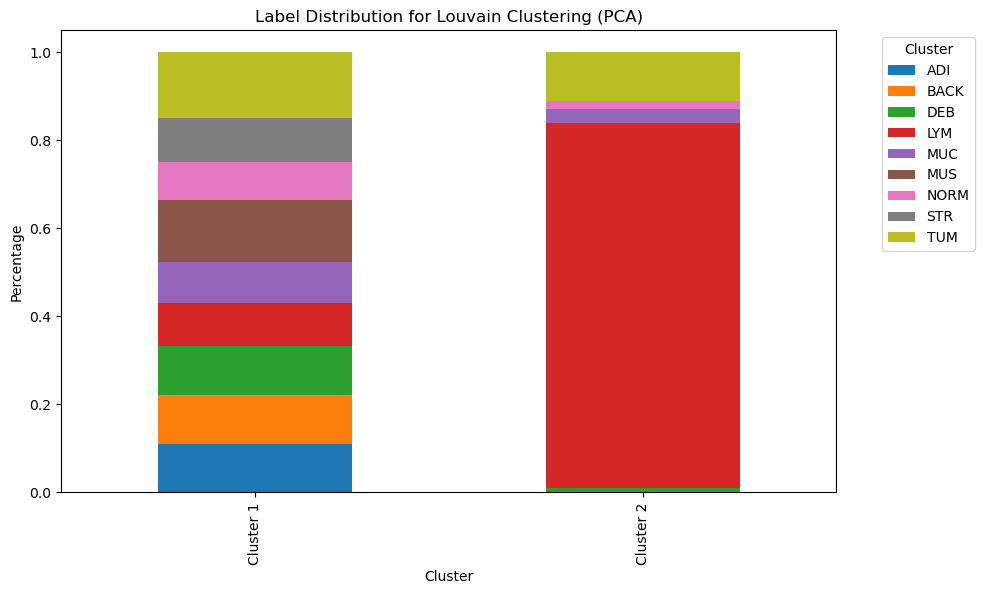

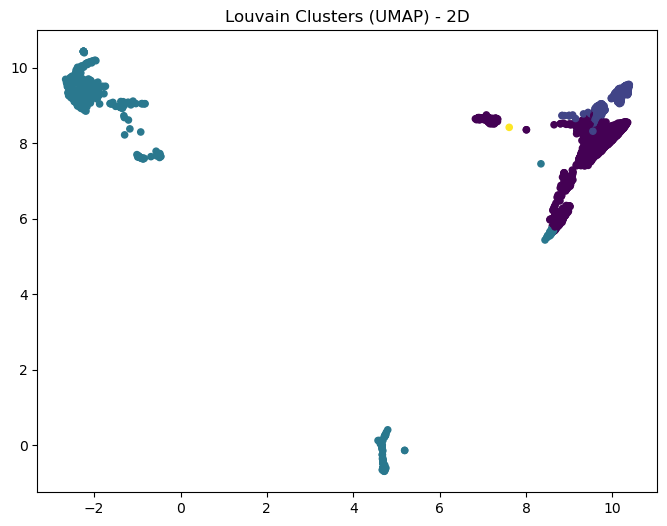

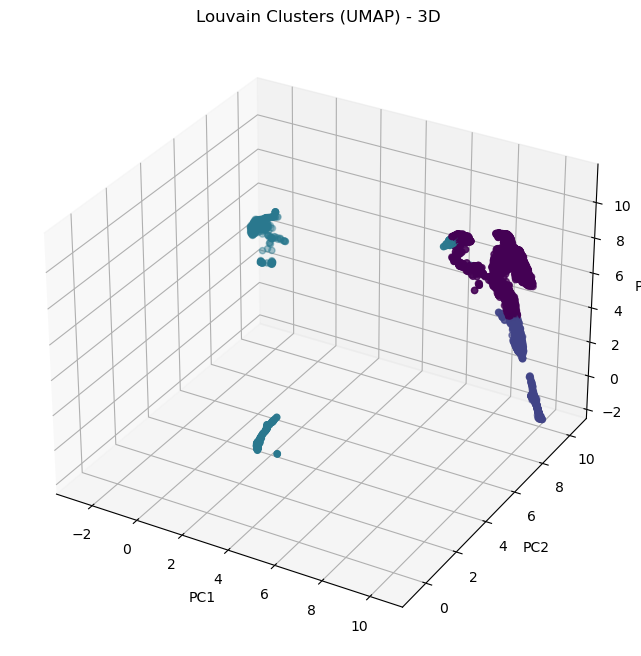


Louvain Clustering (UMAP) Silhouette Score: 0.47227734327316284, V-measure Score: 0.3425585010408788


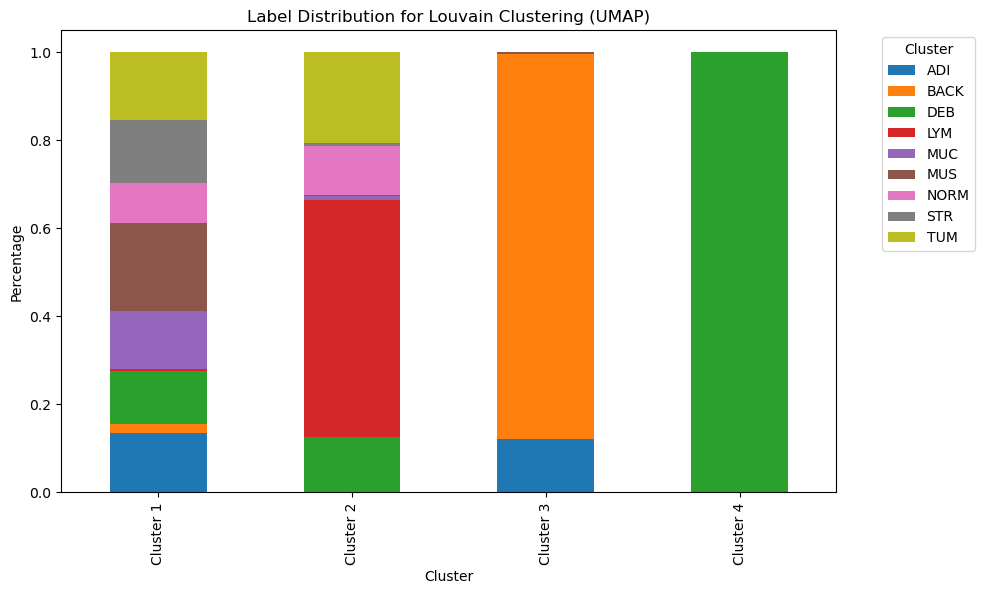

AgglomerativeClustering (PCA) Silhouette Score: 0.3199980854988098, V-measure Score: 0.11237852608290386


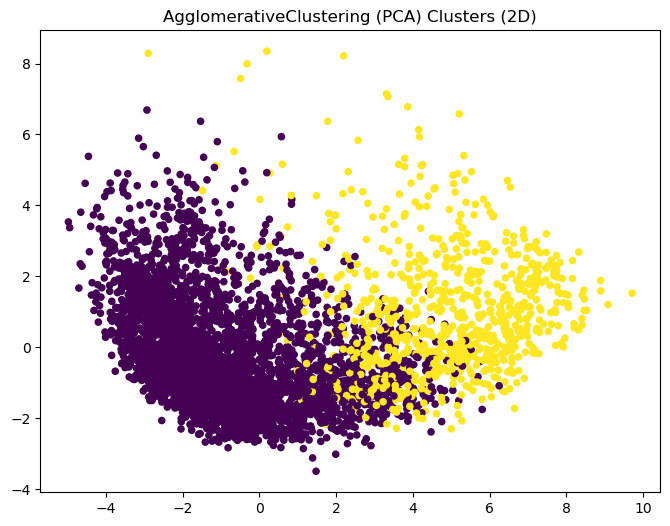

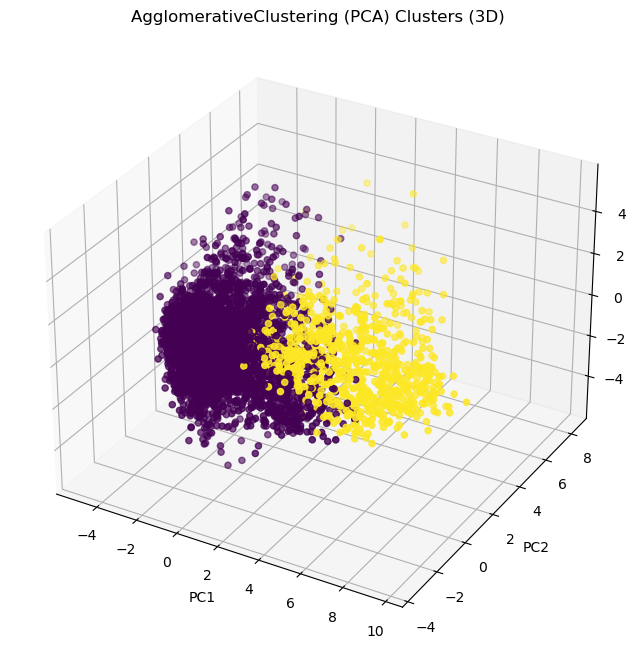

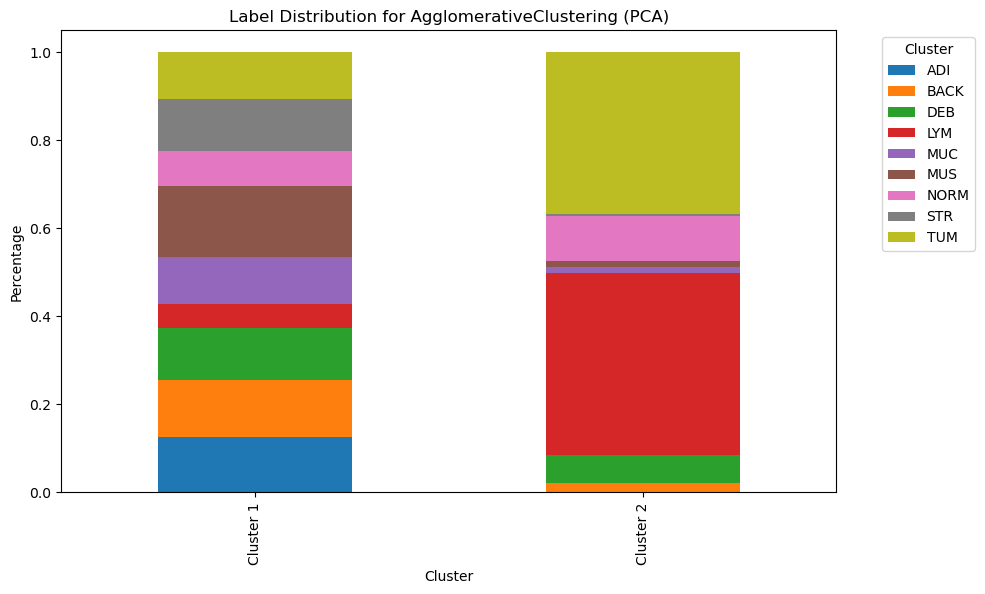

AgglomerativeClustering (UMAP) Silhouette Score: 0.6150474548339844, V-measure Score: 0.525013901431699


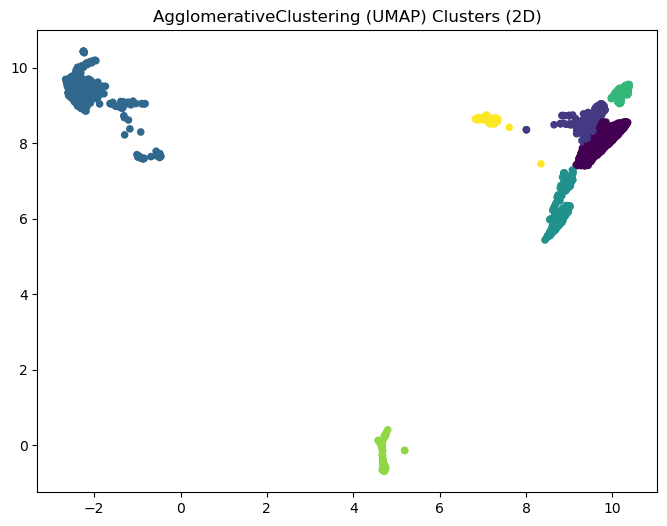

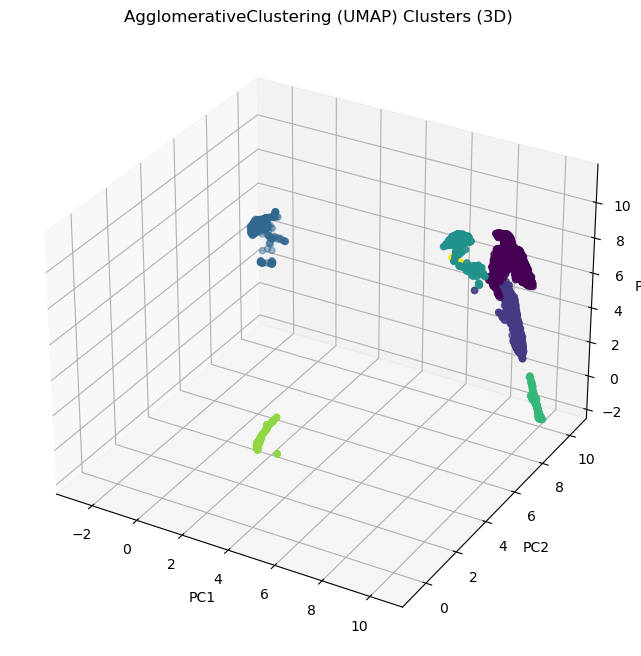

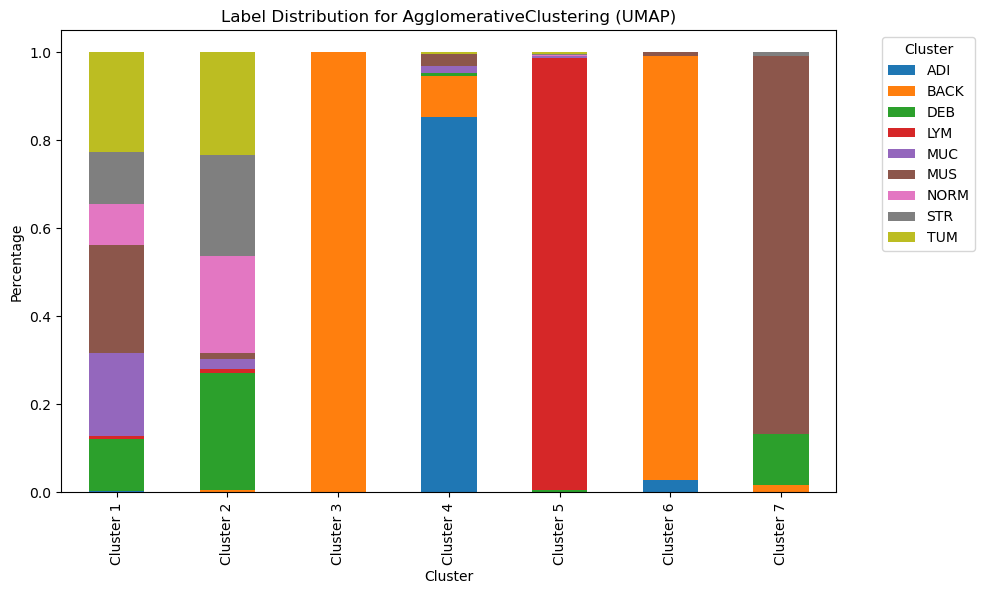

In [5]:
import h5py
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, v_measure_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sknetwork.clustering import Louvain
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances 
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse import csr_matrix
from sklearn.feature_selection import SelectKBest, f_classif
    
# Paths to data files
pge_path = 'pge_dim_reduced_feature.h5'
resnet50_path = 'resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'vgg16_dim_reduced_feature.h5'

# Load data
pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')

# Load PCA features
pge_pca_feature = pge_content['pca_feature'][...]
resnet50_pca_feature = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature = vgg16_content['pca_feature'][...]

# Load UMAP features
pge_umap_feature = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature = vgg16_content['umap_feature'][...]

# Extract tissue labels
filename = np.squeeze(pge_content['file_name'])
filename = np.array([str(x) for x in filename])
labels = np.array([x.split('/')[2] for x in filename])

# Function to visualize clusters in 2D
def plot_clusters_2d(data, assignment, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=assignment, cmap='viridis', s=20)
    plt.title(title)
    plt.show()

# Function to visualize clusters in 3D
def plot_clusters_3d(data, assignment, title):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=assignment, cmap='viridis', s=20)
    ax.set_title(title)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.show()

# Function to perform clustering, evaluate, and visualize results
def perform_clustering_and_evaluation(model, data, true_labels, title):
    assignment = model.fit_predict(data)
    
    # Silhouette and V-measure scores
    silhouette = silhouette_score(data, assignment)
    v_measure = v_measure_score(true_labels, assignment)

    # Print scores
    print(f"{title} Silhouette Score: {silhouette}, V-measure Score: {v_measure}")

    # Visualization
    plot_clusters_2d(data, assignment, title + ' Clusters (2D)')
    plot_clusters_3d(data, assignment, title + ' Clusters (3D)')
    
    plot_label_distribution(assignment,true_labels, f'Label Distribution for {title}')

def plot_label_distribution(cluster_labels, true_labels, title):
    # Feature distribution in clusters
    unique_labels, label_counts = np.unique(true_labels, return_counts=True)
    cluster_label_counts = []
    for cluster in range(cluster_labels.max() + 1):
        cluster_mask = (cluster_labels == cluster)

        # Check if the cluster has any data points
        if np.any(cluster_mask):
            cluster_labels_data = true_labels[cluster_mask]

            # Create a DataFrame to count label occurrences in the cluster
            cluster_df = pd.DataFrame({'Label': cluster_labels_data})
            label_distribution = cluster_df['Label'].value_counts(normalize=True).sort_index()

            # Append the label distribution to the list
            cluster_label_counts.append(label_distribution)

    # Check if there are any non-empty clusters
    if cluster_label_counts:
        # Concatenate the label distributions along the columns
        cluster_label_counts = pd.concat(cluster_label_counts, axis=1).fillna(0).T

        # Plot stacked bar graph
        ax = cluster_label_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title(title)
        plt.xlabel('Cluster')
        plt.xticks(np.arange(len(cluster_label_counts.index)), [f'Cluster {i+1}' for i in range(len(cluster_label_counts.index))])
        plt.ylabel('Percentage')
        ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()


# Scaling the data
#scaler = MinMaxScaler()

# Feature Selection
#k_best_selector = SelectKBest(f_classif, k=10)  # Adjust k as needed

# Apply feature selection and scaling to PCA features
#pge_pca_feature_selected = k_best_selector.fit_transform(pge_pca_feature, labels)
#pge_pca_feature = scaler.fit_transform(pge_pca_feature_selected)

# Apply feature selection and scaling to UMAP features
#pge_umap_feature_selected = k_best_selector.fit_transform(pge_umap_feature, labels)
#pge_umap_feature = scaler.fit_transform(pge_umap_feature_selected)




# 1. PGE :-
print("PGE :-\n\n")

t_range = range(2,10)


# K-Means clustering for PCA features

'''print("\nHyperparameter tuning for K-Means clustering (PCA)")
inertia_scores = []
for n in t_range:
    kmeans_model_pca = KMeans(n_clusters=n, random_state=0)
    cluster_assignments = kmeans_model_pca.fit(pge_pca_feature)
    inertia_scores.append(kmeans_model_pca.inertia_)
plt.plot(t_range, inertia_scores)'''

kmeans_model_pca = KMeans(n_clusters=7, random_state=0)
perform_clustering_and_evaluation(kmeans_model_pca, pge_pca_feature, labels, 'K-Means (PCA)')


# Visualization for K-Means clustering with UMAP features

'''print("\nHyperparameter tuning for K-Means clustering (UMAP)")
inertia_scores2 = []
for n in t_range:
    kmeans_model_umap = KMeans(n_clusters=n, random_state=0)
    cluster_assignments = kmeans_model_umap.fit(pge_umap_feature)
    inertia_scores2.append(kmeans_model_umap.inertia_)
plt.plot(t_range, inertia_scores2)'''

kmeans_model_umap = KMeans(n_clusters=7, random_state=0)
perform_clustering_and_evaluation(kmeans_model_umap, pge_umap_feature, labels, 'K-Means (UMAP)')



# Gaussian Mixture Model (GMM) clustering for PCA features

'''print("\nHyperparameter tuning for GMM clustering (PCA)")
silhouette_scores = []
for n in t_range:
    gmm_model_pca = GaussianMixture(n_components=n, random_state=0)
    cluster_assignments = gmm_model_pca.fit_predict(pge_pca_feature)
    silhouette_scores.append(silhouette_score(pge_pca_feature, cluster_assignments))
plt.plot(t_range, silhouette_scores)'''

gmm_model_pca = GaussianMixture(n_components=4, random_state=0)
perform_clustering_and_evaluation(gmm_model_pca, pge_pca_feature, labels, 'Gaussian Mixture Model (PCA)')


# Visualization for Gaussian Mixture Model (GMM) clustering with UMAP features

'''print("\nHyperparameter tuning for GMM clustering (UMAP)")
silhouette_score2 = []
for n in t_range:
    gmm_model_umap = GaussianMixture(n_components=n, random_state=0)
    cluster_assignments = gmm_model_umap.fit_predict(pge_umap_feature)
    silhouette_score2.append(silhouette_score(pge_umap_feature, cluster_assignments))
plt.plot(t_range, silhouette_score2)'''

gmm_model_umap = GaussianMixture(n_components=6, random_state=0)
perform_clustering_and_evaluation(gmm_model_umap, pge_umap_feature, labels, 'GMM (UMAP)')



# Louvain Clustering for PCA features

'''print("\n\nHyperparameter tuning for Louvain Clustering (PCA)")
resolutions = np.arange(0.9, 1.5, 0.1)
silhouette_score3 = []

for resolution in resolutions:
    louvain_model = Louvain(resolution=resolution, modularity='Newman', random_state=0)
    adjacency_matrix = csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_pca_feature)))
    louvain_assignment = louvain_model.fit_transform(adjacency_matrix).toarray()
    cluster_labels = np.argmax(louvain_assignment, axis=1)
    # Evaluate clustering performance (using silhouette score)
    silhouette_score3.append(silhouette_score(pge_pca_feature, cluster_labels))
plt.plot(resolutions, silhouette_score3)'''

louvain_model_pca = Louvain(resolution=0.9, modularity='Newman', random_state=0)
adjacency_matrix_pca = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_pca_feature)))
louvain_assignment_pca = louvain_model_pca.fit_transform(adjacency_matrix_pca).toarray()  # Convert to dense array
cluster_labels_pca = np.argmax(louvain_assignment_pca, axis=1)  # Get the index of the maximum score as the assigned cluster

# Visualization for Louvain clustering with PCA features
plot_clusters_2d(pge_pca_feature, cluster_labels_pca, 'Louvain Clusters (PCA) - 2D')
plot_clusters_3d(pge_pca_feature, cluster_labels_pca, 'Louvain Clusters (PCA) - 3D')
# Silhouette and V-measure scores
silhouette_louvain_pca = silhouette_score(pge_pca_feature, cluster_labels_pca)
v_measure_louvain_pca = v_measure_score(labels, cluster_labels_pca)
print(f"\nLouvain Clustering (PCA) Silhouette Score: {silhouette_louvain_pca}, V-measure Score: {v_measure_louvain_pca}")

plot_label_distribution(cluster_labels_pca, labels, 'Label Distribution for Louvain Clustering (PCA)' )


# Louvain Clustering for UMAP features

'''print("\n\nHyperparameter tuning for Louvain Clustering (UMAP)")
silhouette_score4 = []
for resolution in resolutions:
    louvain_model = Louvain(resolution=resolution, modularity='Newman', random_state=0)
    adjacency_matrix = csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_umap_feature)))
    louvain_assignment = louvain_model.fit_transform(adjacency_matrix).toarray()
    cluster_labels = np.argmax(louvain_assignment, axis=1)
    # Evaluate clustering performance (using silhouette score)
    silhouette_score4.append(silhouette_score(pge_umap_feature, cluster_labels))
plt.plot(resolutions, silhouette_score4)'''

louvain_model_umap = Louvain(resolution=1.1, modularity='Newman', random_state=0)
adjacency_matrix_umap = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_umap_feature)))
louvain_assignment_umap = louvain_model_umap.fit_transform(adjacency_matrix_umap).toarray()  # Convert to dense array
cluster_labels_umap = np.argmax(louvain_assignment_umap, axis=1)  # Get the index of the maximum score as the assigned cluster

# Visualization for Louvain clustering with UMAP features
plot_clusters_2d(pge_umap_feature, cluster_labels_umap, 'Louvain Clusters (UMAP) - 2D')
plot_clusters_3d(pge_umap_feature, cluster_labels_umap, 'Louvain Clusters (UMAP) - 3D')
# Silhouette and V-measure scores
silhouette_louvain_umap = silhouette_score(pge_umap_feature, cluster_labels_umap)
v_measure_louvain_umap = v_measure_score(labels, cluster_labels_umap)
print(f"\nLouvain Clustering (UMAP) Silhouette Score: {silhouette_louvain_umap}, V-measure Score: {v_measure_louvain_umap}")

plot_label_distribution(cluster_labels_umap, labels, 'Label Distribution for Louvain Clustering (UMAP)' )


# AgglomerativeClustering clustering for PCA features

'''print("\n\nHyperparameter tuning for AgglomerativeClustering (PCA)")
silhouette_score3 = []
for n in t_range:
    hierarchical_model_pca = AgglomerativeClustering(n_clusters=n)
    cluster_assignments = hierarchical_model_pca.fit_predict(pge_pca_feature)
    silhouette_score3.append(silhouette_score(pge_pca_feature, cluster_assignments))
plt.plot(t_range, silhouette_score3)'''

hierarchical_model_pca = AgglomerativeClustering(n_clusters=2)
perform_clustering_and_evaluation(hierarchical_model_pca, pge_pca_feature, labels, 'AgglomerativeClustering (PCA)')


# Visualization for AgglomerativeClustering clustering with UMAP features

'''print("\nHyperparameter tuning for AgglomerativeClustering (UMAP)")
silhouette_score4 = []
for n in t_range:
    hierarchical_model_pca = AgglomerativeClustering(n_clusters=n)
    cluster_assignments = hierarchical_model_pca.fit_predict(pge_umap_feature)
    silhouette_score4.append(silhouette_score(pge_umap_feature, cluster_assignments))
plt.plot(t_range, silhouette_score4)'''

hierarchical_model_umap = AgglomerativeClustering(n_clusters=7)
perform_clustering_and_evaluation(hierarchical_model_umap, pge_umap_feature, labels, 'AgglomerativeClustering (UMAP)')






 RESNET50 :-




C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means (PCA) Silhouette Score: 0.16711243987083435, V-measure Score: 0.4792995824222987


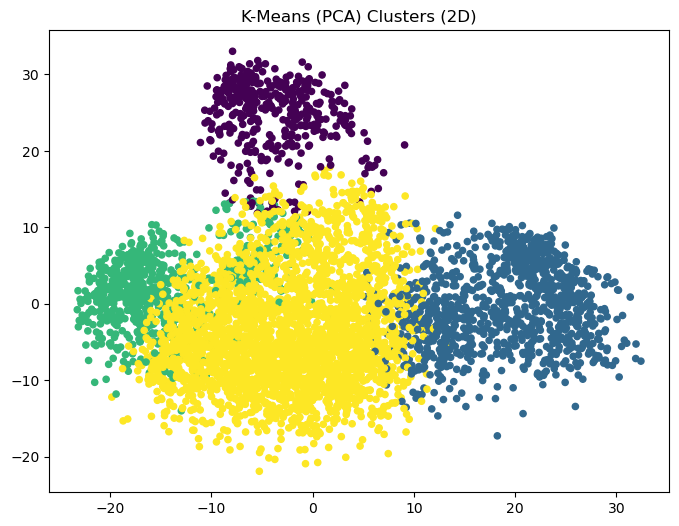

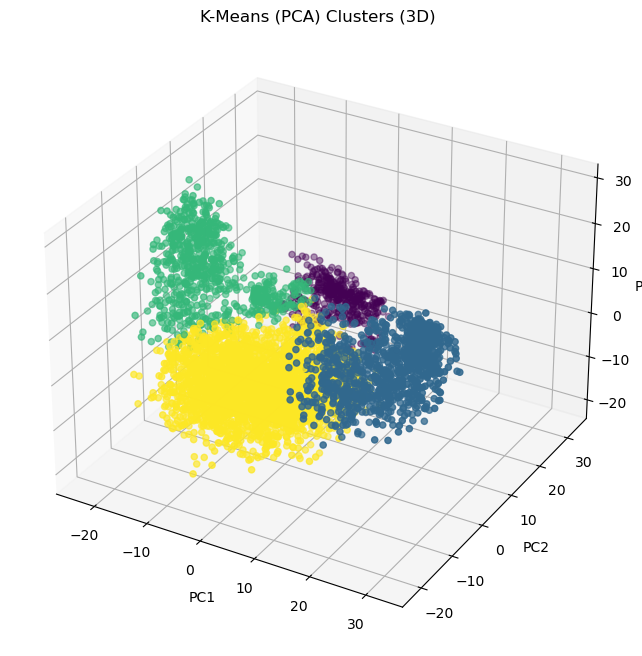

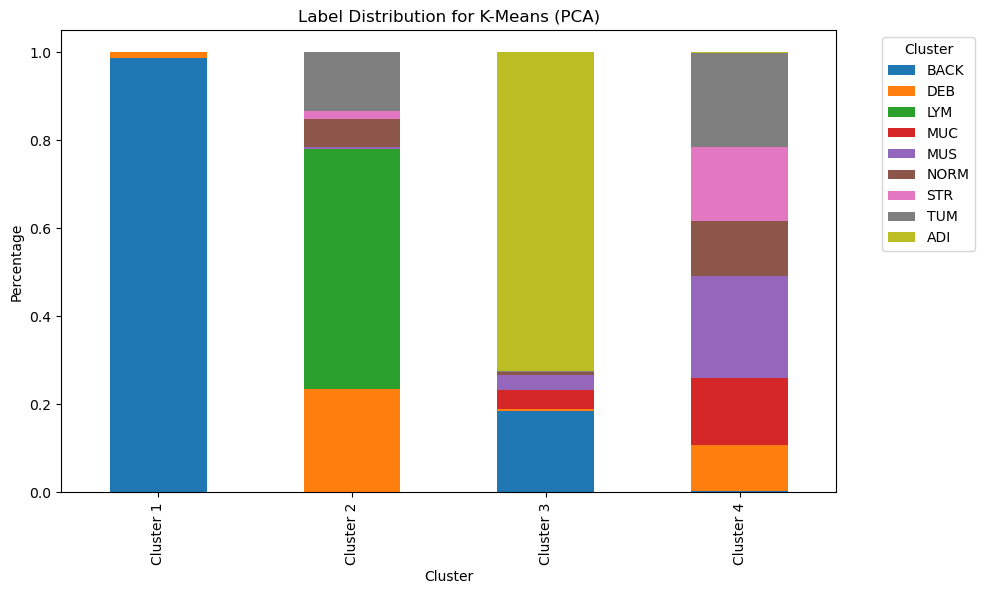

C:\Users\aadit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means (UMAP) Silhouette Score: 0.5835224390029907, V-measure Score: 0.5265567634658621


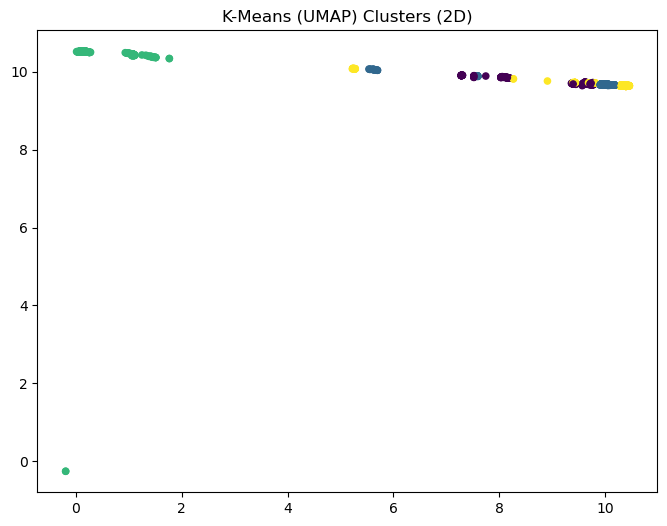

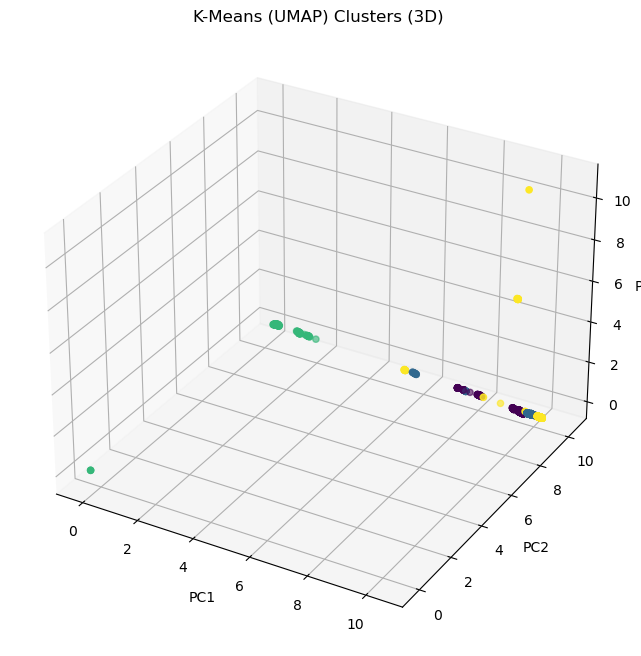

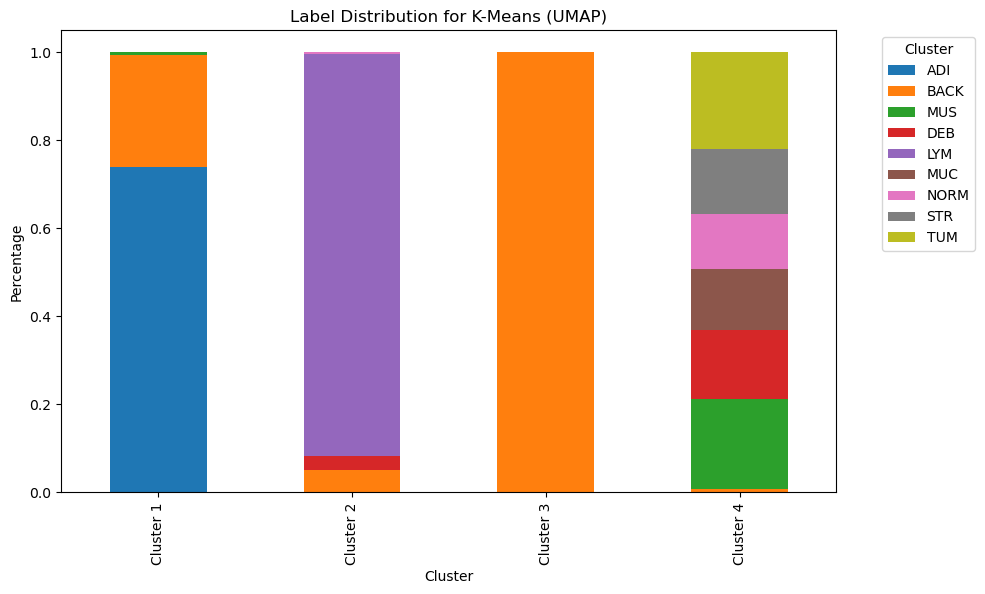

Gaussian Mixture Model (PCA) Silhouette Score: 0.15566790103912354, V-measure Score: 0.5229571496869431


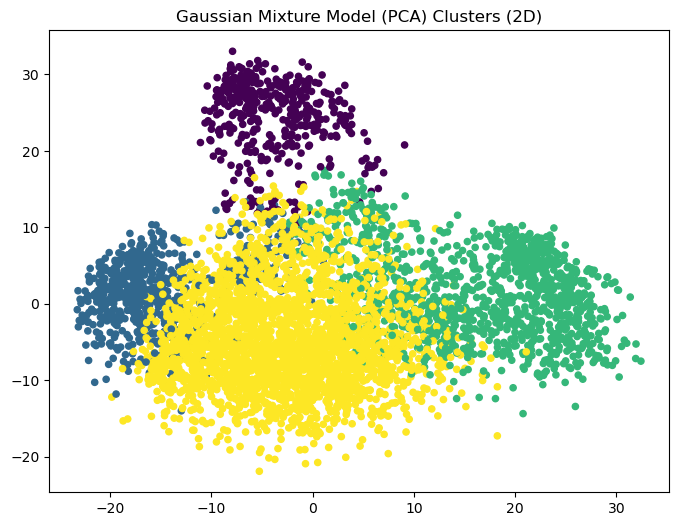

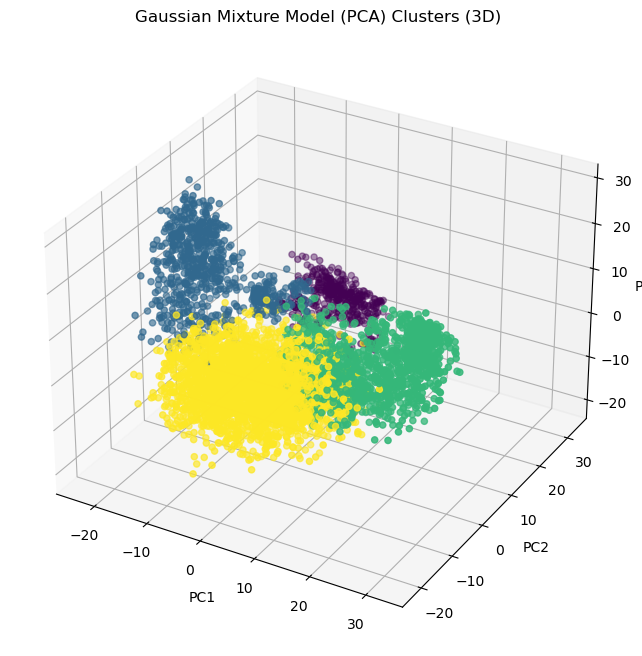

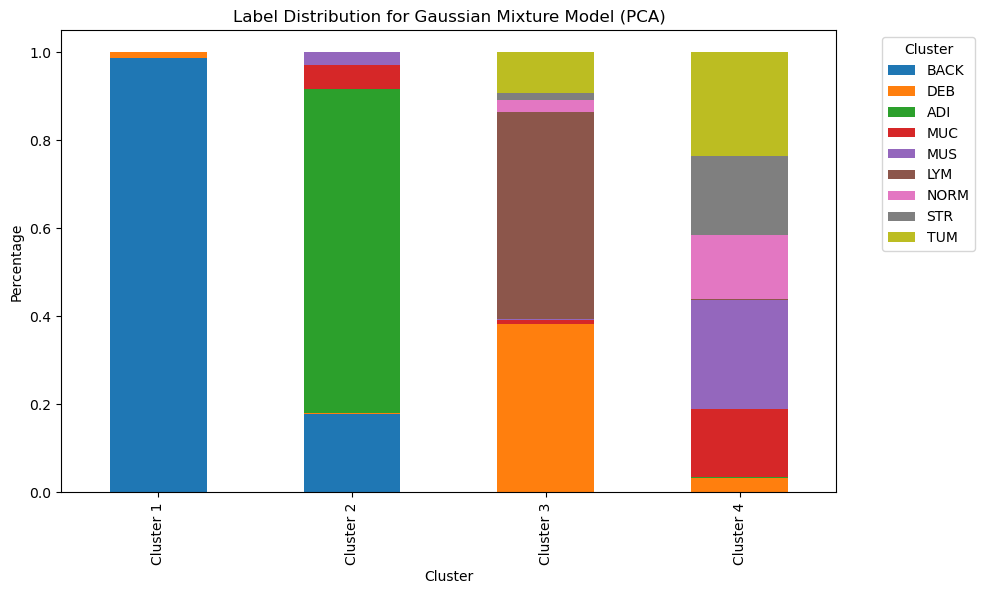

GMM (UMAP) Silhouette Score: 0.6105461120605469, V-measure Score: 0.5638448077239075


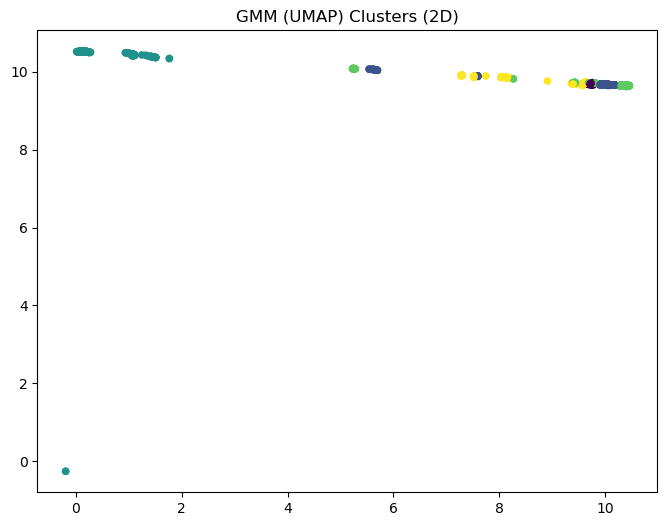

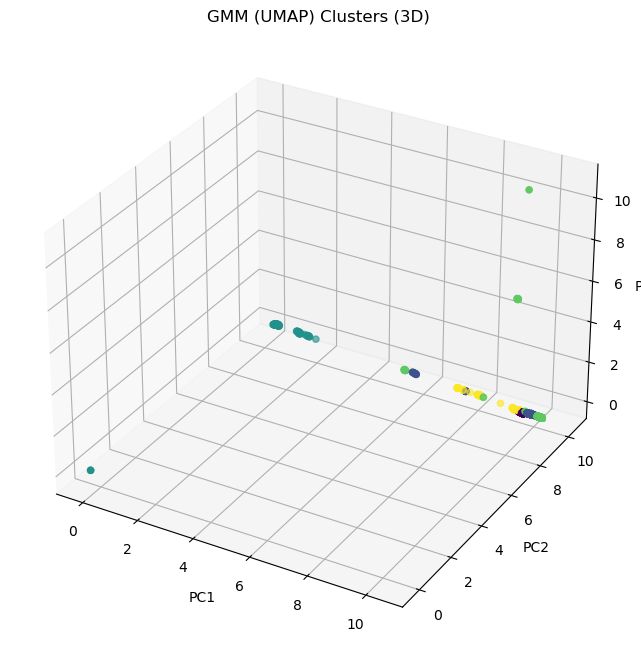

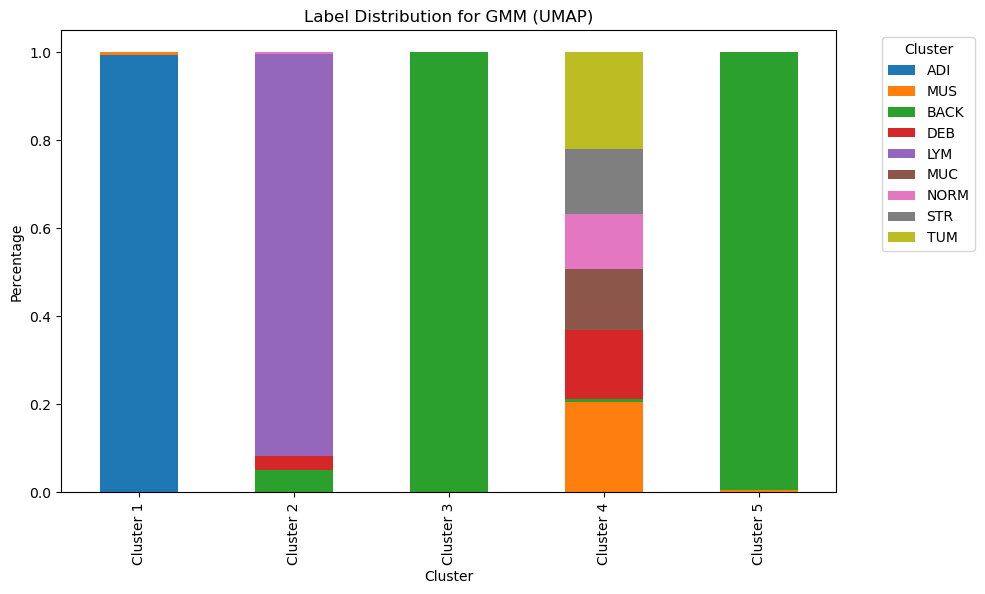

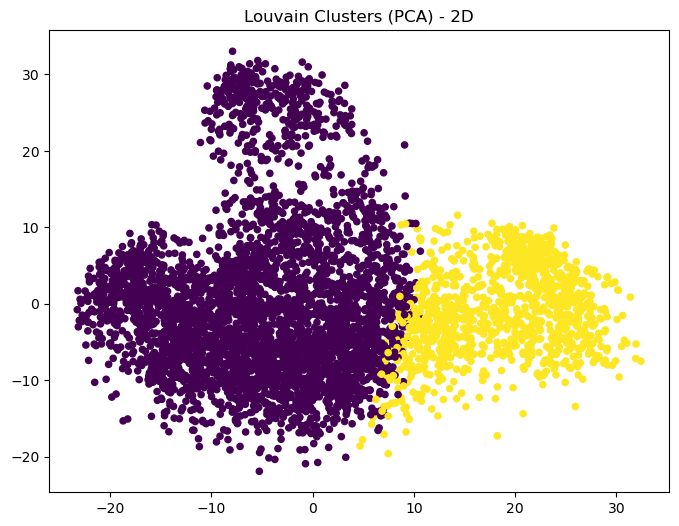

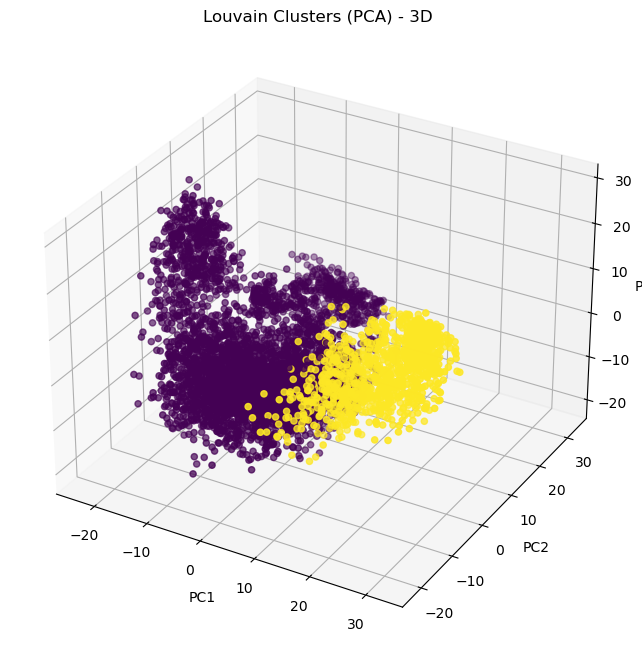


Louvain Clustering (PCA) Silhouette Score: 0.14328524470329285, V-measure Score: 0.21204259300560835


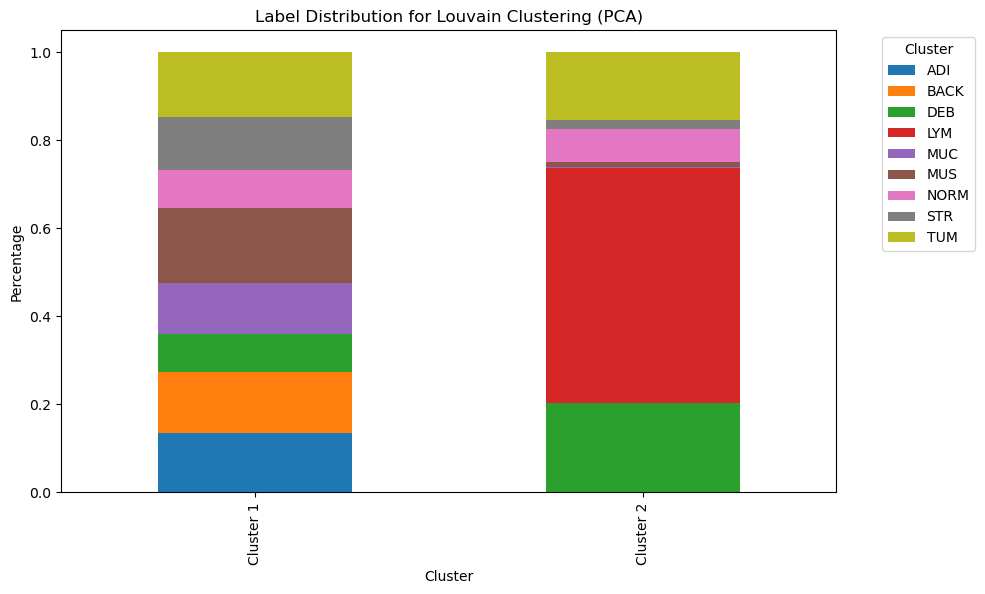

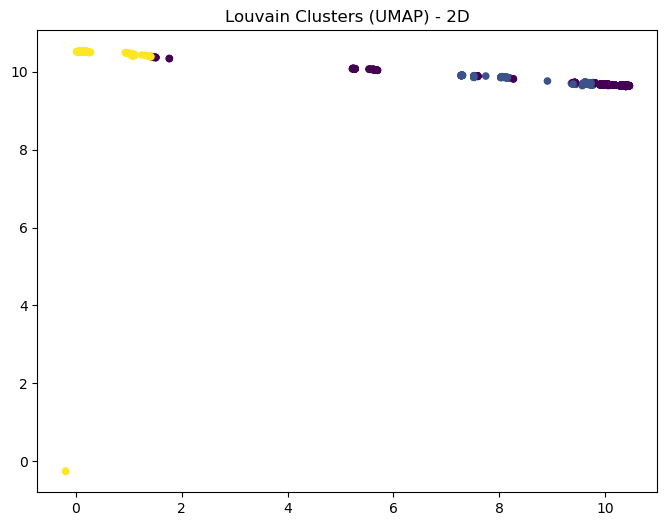

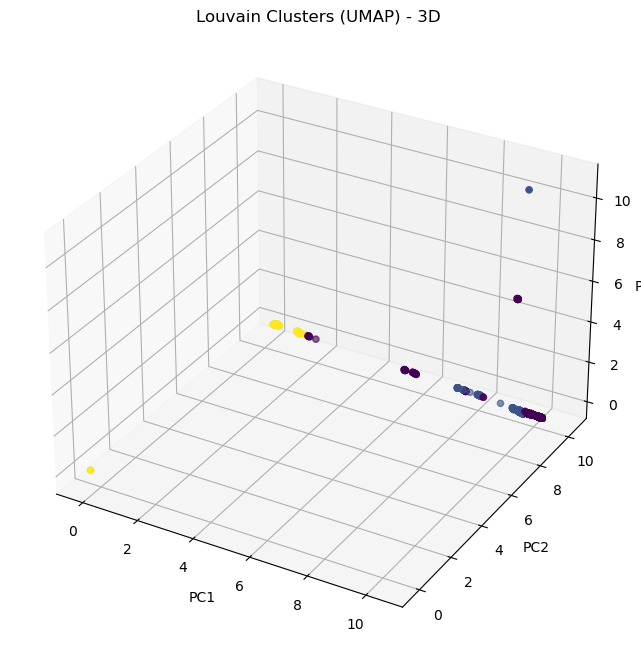


Louvain Clustering (UMAP) Silhouette Score: 0.5402557849884033, V-measure Score: 0.3612491058538738


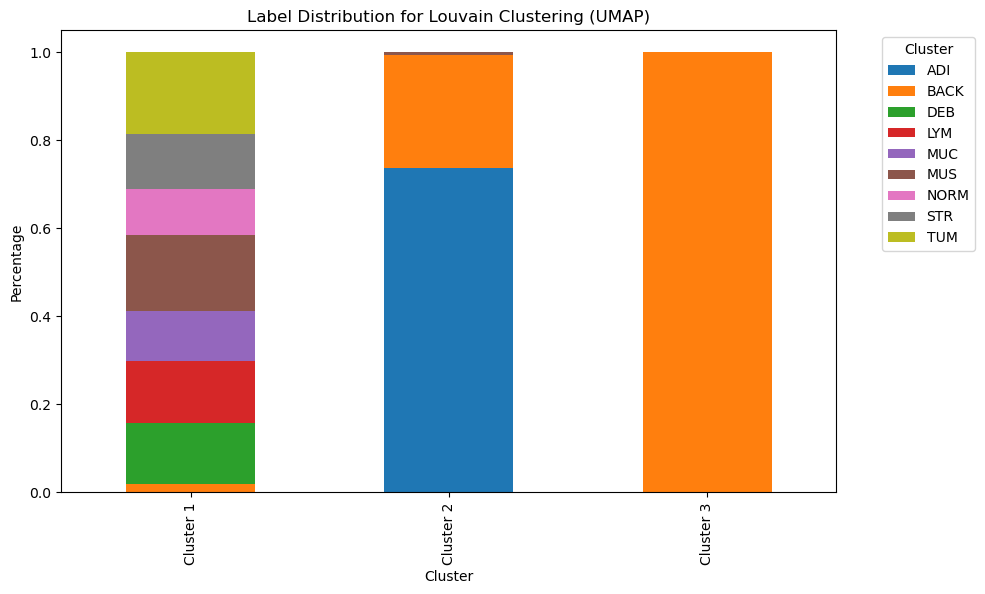


AgglomerativeClustering (PCA) Silhouette Score: 0.1515624076128006, V-measure Score: 0.5040995440199796


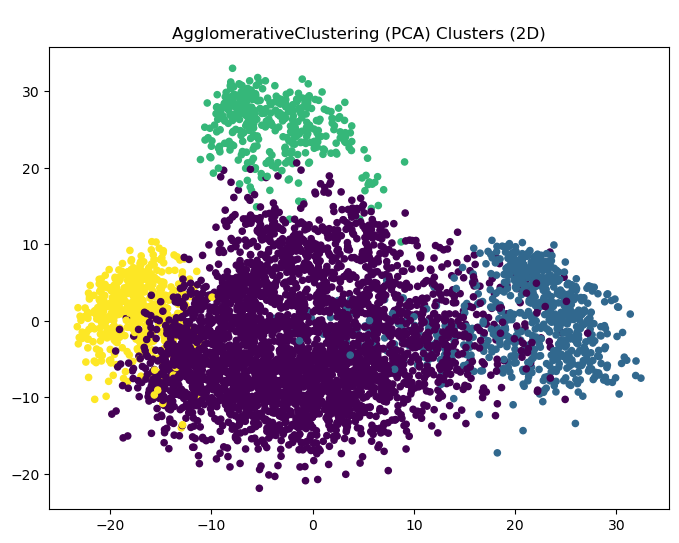

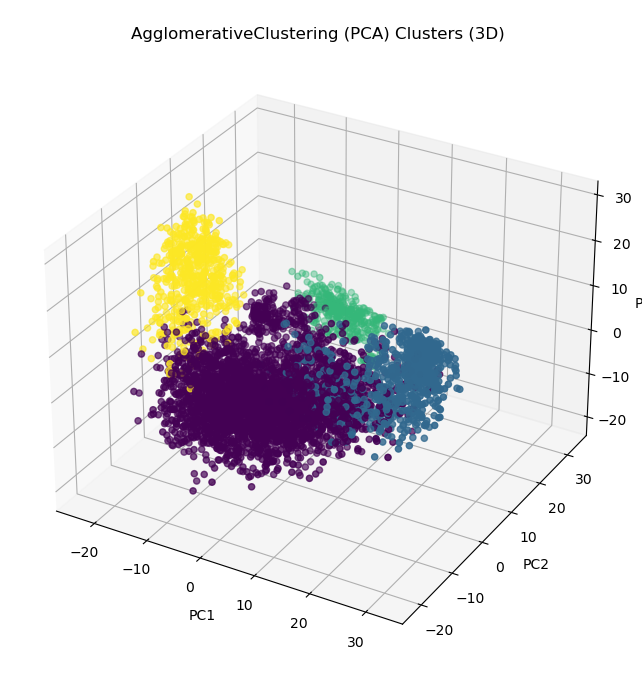

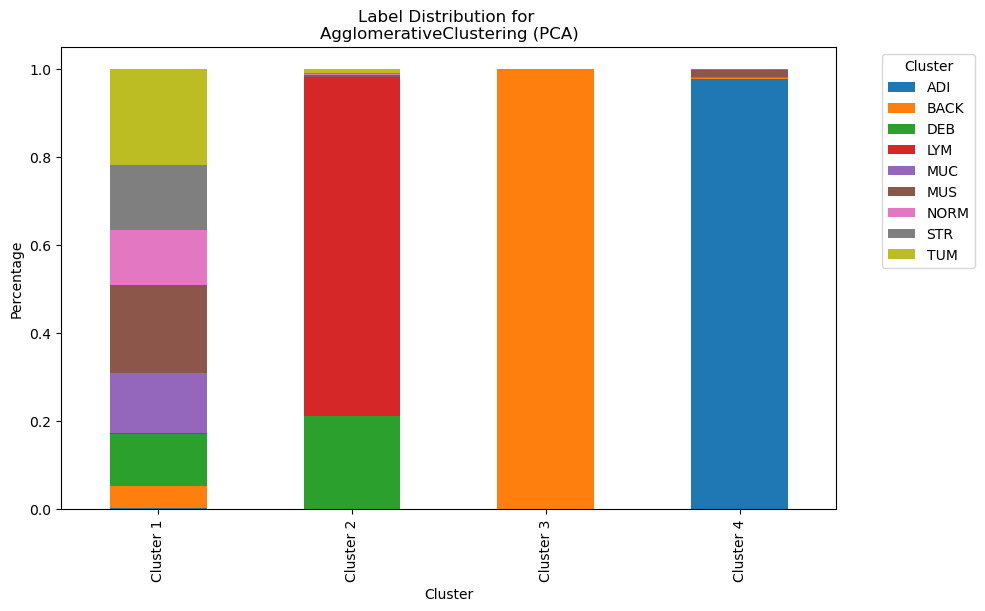


AgglomerativeClustering (UMAP) Silhouette Score: 0.6150474548339844, V-measure Score: 0.525013901431699


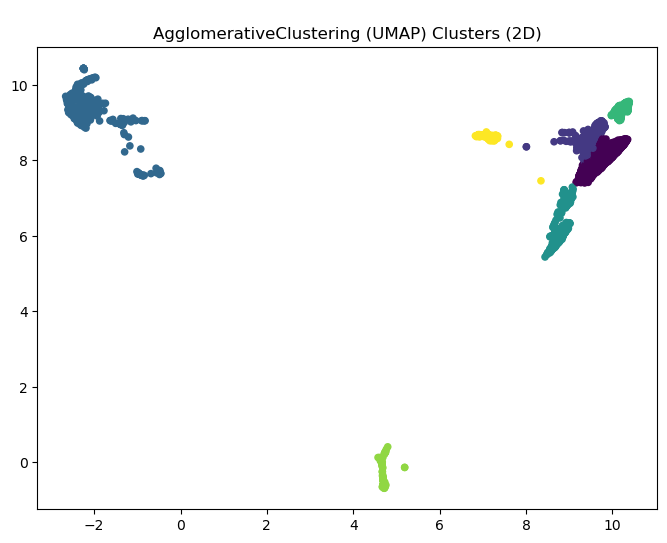

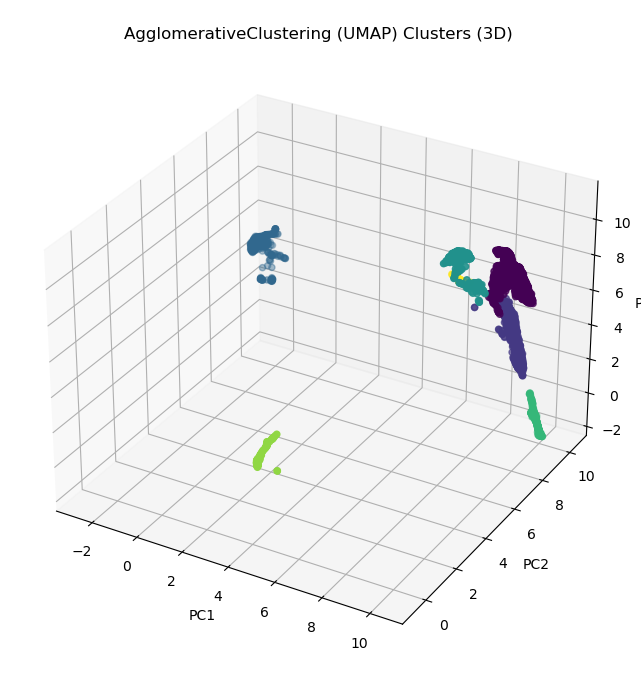

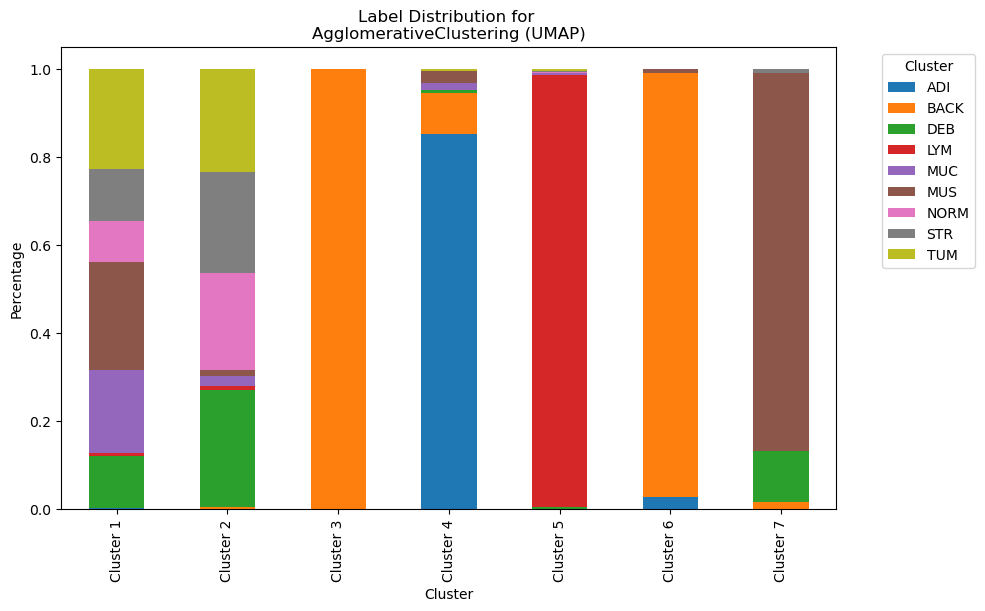

In [6]:
# RESNET50 :-
print("\n\n\n RESNET50 :-\n\n")

# K-Means clustering for PCA features

'''print("\nHyperparameter tuning for K-Means clustering (PCA)")
inertia_scores = []
for n in t_range:
    kmeans_model_pca = KMeans(n_clusters=n, random_state=0)
    cluster_assignments = kmeans_model_pca.fit(resnet50_pca_feature)
    inertia_scores.append(kmeans_model_pca.inertia_)
plt.plot(t_range, inertia_scores)'''

kmeans_model_pca = KMeans(n_clusters=4, random_state=0)
perform_clustering_and_evaluation(kmeans_model_pca, resnet50_pca_feature, labels, 'K-Means (PCA)')


# Visualization for K-Means clustering with UMAP features

'''print("\nHyperparameter tuning for K-Means clustering (UMAP)")
inertia_scores2 = []
for n in t_range:
    kmeans_model_umap = KMeans(n_clusters=n, random_state=0)
    cluster_assignments = kmeans_model_umap.fit(resnet50_umap_feature)
    inertia_scores2.append(kmeans_model_umap.inertia_)
plt.plot(t_range, inertia_scores2)'''

kmeans_model_umap = KMeans(n_clusters=4, random_state=0)
perform_clustering_and_evaluation(kmeans_model_umap, resnet50_umap_feature, labels, 'K-Means (UMAP)')




# Gaussian Mixture Model (GMM) clustering for PCA features

'''print("\nHyperparameter tuning for GMM clustering (PCA)")
silhouette_scores = []
for n in t_range:
    gmm_model_pca = GaussianMixture(n_components=n, random_state=0)
    cluster_assignments = gmm_model_pca.fit_predict(resnet50_pca_feature)
    silhouette_scores.append(silhouette_score(resnet50_pca_feature, cluster_assignments))
plt.plot(t_range, silhouette_scores)'''

gmm_model_pca = GaussianMixture(n_components=4, random_state=0)
perform_clustering_and_evaluation(gmm_model_pca, resnet50_pca_feature, labels, 'Gaussian Mixture Model (PCA)')


# Visualization for Gaussian Mixture Model (GMM) clustering with UMAP features

'''print("\nHyperparameter tuning for GMM clustering (UMAP)")
silhouette_score2 = []
for n in t_range:
    gmm_model_umap = GaussianMixture(n_components=n, random_state=0)
    cluster_assignments = gmm_model_umap.fit_predict(resnet50_umap_feature)
    silhouette_score2.append(silhouette_score(resnet50_umap_feature, cluster_assignments))
plt.plot(t_range, silhouette_score2)'''

gmm_model_umap = GaussianMixture(n_components=5, random_state=0)
perform_clustering_and_evaluation(gmm_model_umap, resnet50_umap_feature, labels, 'GMM (UMAP)')



# Louvain Clustering for PCA features

'''print("\n\nHyperparameter tuning for Louvain Clustering (PCA)")
resolutions = np.arange(0.9, 1.5, 0.1)
silhouette_scores = []

for resolution in resolutions:
    louvain_model = Louvain(resolution=resolution, modularity='Newman', random_state=0)
    adjacency_matrix = csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(resnet50_pca_feature)))
    louvain_assignment = louvain_model.fit_transform(adjacency_matrix).toarray()
    cluster_labels = np.argmax(louvain_assignment, axis=1)
    # Evaluate clustering performance (using silhouette score)
    silhouette_scores.append(silhouette_score(resnet50_pca_feature, cluster_labels))
plt.plot(resolutions, silhouette_scores)'''

louvain_model_pca = Louvain(resolution=1.0, modularity='Newman', random_state=0)
adjacency_matrix_pca = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(resnet50_pca_feature)))
louvain_assignment_pca = louvain_model_pca.fit_transform(adjacency_matrix_pca).toarray()  # Convert to dense array
cluster_labels_pca = np.argmax(louvain_assignment_pca, axis=1)  # Get the index of the maximum score as the assigned cluster

# Visualization for Louvain clustering with PCA features
plot_clusters_2d(resnet50_pca_feature, cluster_labels_pca, 'Louvain Clusters (PCA) - 2D')
plot_clusters_3d(resnet50_pca_feature, cluster_labels_pca, 'Louvain Clusters (PCA) - 3D')
# Silhouette and V-measure scores
silhouette_louvain_pca = silhouette_score(resnet50_pca_feature, cluster_labels_pca)
v_measure_louvain_pca = v_measure_score(labels, cluster_labels_pca)
print(f"\nLouvain Clustering (PCA) Silhouette Score: {silhouette_louvain_pca}, V-measure Score: {v_measure_louvain_pca}")

plot_label_distribution(cluster_labels_pca, labels, 'Label Distribution for Louvain Clustering (PCA)' )

# Louvain Clustering for UMAP features

'''print("\n\nHyperparameter tuning for Louvain Clustering (UMAP)")
silhouette_scores = []

for resolution in resolutions:
    louvain_model = Louvain(resolution=resolution, modularity='Newman', random_state=0)
    adjacency_matrix = csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(resnet50_umap_feature)))
    louvain_assignment = louvain_model.fit_transform(adjacency_matrix).toarray()
    cluster_labels = np.argmax(louvain_assignment, axis=1)
    # Evaluate clustering performance (using silhouette score)
    silhouette_scores.append(silhouette_score(resnet50_umap_feature, cluster_labels))
plt.plot(resolutions, silhouette_scores)'''

louvain_model_umap = Louvain(resolution=1.2, modularity='Newman', random_state=0)
adjacency_matrix_umap = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(resnet50_umap_feature)))
louvain_assignment_umap = louvain_model_umap.fit_transform(adjacency_matrix_umap).toarray()  # Convert to dense array
cluster_labels_umap = np.argmax(louvain_assignment_umap, axis=1)  # Get the index of the maximum score as the assigned cluster

# Visualization for Louvain clustering with UMAP features
plot_clusters_2d(resnet50_umap_feature, cluster_labels_umap, 'Louvain Clusters (UMAP) - 2D')
plot_clusters_3d(resnet50_umap_feature, cluster_labels_umap, 'Louvain Clusters (UMAP) - 3D')
# Silhouette and V-measure scores
silhouette_louvain_umap = silhouette_score(resnet50_umap_feature, cluster_labels_umap)
v_measure_louvain_umap = v_measure_score(labels, cluster_labels_umap)
print(f"\nLouvain Clustering (UMAP) Silhouette Score: {silhouette_louvain_umap}, V-measure Score: {v_measure_louvain_umap}")

plot_label_distribution(cluster_labels_umap, labels, 'Label Distribution for Louvain Clustering (UMAP)' )


# AgglomerativeClustering clustering for PCA features

'''print("\n\nHyperparameter tuning for AgglomerativeClustering (PCA)")
silhouette_score3 = []
for n in t_range:
    hierarchical_model_pca = AgglomerativeClustering(n_clusters=n)
    cluster_assignments = hierarchical_model_pca.fit_predict(resnet50_pca_feature)
    silhouette_score3.append(silhouette_score(resnet50_pca_feature, cluster_assignments))
plt.plot(t_range, silhouette_score3)'''

hierarchical_model_pca = AgglomerativeClustering(n_clusters=4)
perform_clustering_and_evaluation(hierarchical_model_pca, resnet50_pca_feature, labels, '\nAgglomerativeClustering (PCA)')


# Visualization for AgglomerativeClustering clustering with UMAP features

'''print("\nHyperparameter tuning for AgglomerativeClustering (UMAP)")
silhouette_score4 = []
for n in t_range:
    hierarchical_model_pca = AgglomerativeClustering(n_clusters=n)
    cluster_assignments = hierarchical_model_pca.fit_predict(pge_umap_feature)
    silhouette_score4.append(silhouette_score(pge_umap_feature, cluster_assignments))
plt.plot(t_range, silhouette_score4)'''

hierarchical_model_umap = AgglomerativeClustering(n_clusters=7)
perform_clustering_and_evaluation(hierarchical_model_umap, pge_umap_feature, labels, '\nAgglomerativeClustering (UMAP)')

